In [1]:
#initialising Spark
import findspark
findspark.init("/u/cs451/packages/spark")

In [6]:
# Creating a spark session
from pyspark.sql import SparkSession
import random
spark = SparkSession.builder.appName("YourTest").master("local[2]").\
    config('spark.ui.port', random.randrange(4000,5000)).getOrCreate()

In [1]:
# Importing the required libraries
from pyspark.sql.functions import *
from pyspark.ml.feature import Tokenizer, StopWordsRemover
import matplotlib.pyplot as plt
from pyspark.ml.feature import NGram
from pyspark.sql.types import IntegerType, StringType, ArrayType, FloatType
import pandas as pd
import re
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, CountVectorizer,StringIndexer, VectorAssembler
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import shutil, os
import networkx as nx
#from pyspark.sql.functions import udf, explode
#from nltk.stem.snowball import SnowballStemmer
#from wordcloud import WordCloud
#from nltk.sentiment.vader import SentimentIntensityAnalyzer
#import nltk

ModuleNotFoundError: No module named 'pyspark'

# Cleaning the tweets's text

In [8]:
# Reading the tweets csv file
tweets_raw = spark.read.csv('tweets.csv', header=True, inferSchema=True, multiLine=True, encoding="UTF-8", sep=',', quote='"',escape='"')

In [9]:
# Cleaning the text

# Using regexp to keep digits, letters, and certain symbols only
#text_raw = tweets_raw.select('handle', 'text', (regexp_replace('text', "(&amp)+|(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|([^0-9A-Za-z \t'-])|(\w+:\/\/\S+)", "")).alias('text_clean'), 'is_retweet', 'original_author', month('time').alias('month') , 'lang', 'retweet_count', 'favorite_count')
text_raw = tweets_raw.select('handle', (regexp_replace('text', "(&amp)+|(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|([^0-9A-Za-z \t'-])|(\w+:\/\/\S+)", "")).alias('text_clean'), 'is_retweet', 'original_author',month('time').alias('month') ,'place_name', 'lang', 'retweet_count', 'favorite_count')
#text_raw = tweets_raw.select('handle', (regexp_replace('text', "([^0-9A-Za-z \\s'])|(\w+:\/\/\S+)", "")).alias('text'), 'is_retweet', 'original_author','time' ,'place_name', 'lang', 'retweet_count', 'favorite_count')



# Removed &,@[A-Za-z0-9],#[A-Za-z0-9], https:....

In [10]:
#tokenising the tweets
tokenizer = Tokenizer(inputCol="text_clean", outputCol="words") #"words_tok")
tokenised = tokenizer.transform(text_raw)

# Filter out the words of length less than 3 characters 
filter_length_udf = udf(lambda row: [x for x in row if len(x) > 2], ArrayType(StringType()))
filtered = tokenised.withColumn('words_filtered', filter_length_udf(col('words')))

#removing the stopwords
remover = StopWordsRemover(inputCol="words_filtered", outputCol="words_clean")
sw_removed = remover.transform(filtered)



#preparing data for different steps, that use a certain level of cleaning
w = filtered.select('handle', 'is_retweet','original_author', 'month','place_name', 'lang','retweet_count', 'favorite_count',col('words_filtered').alias('words'))
tweets_tok = sw_removed.select('handle','is_retweet','original_author', 'month','place_name', 'lang','retweet_count', 'favorite_count',col('words_clean').alias('words_fil'))


# Tokenised, filtered words of character length 2 or less, removed stop words

# Popular N-grams distribution

In [37]:
# Distribution of the popular Ngrams
def n_gram_dist():
    a = True
    print("Let's explore the list Ngrams, that Trump or hilary likely used.\n" +
    "What we will do is ask you a few questions to formulate a query for \n" +
    "plotting the list of top used N grams, the average number of retweets and \n"+
    "average number of favorite the tweets got, that had these Ngrams")
    while a:
        
        tw = input("Whose tweets would you like to analyse \n"+
                  "enter 'H' for Hilary, 'T' for Trump (return to quit): \n ")
        if tw.lower() == "h":
            person = "HillaryClinton"
            break
        elif tw.lower() == "t":
            person = "realDonaldTrump"
            break
    
    #choosing the n for the Ngram
    while a:
        n = input("For the Ngram analysis, enter the value of N anywhere between 1 and 3 (return to quit): \n ")
        try:
            int(n)
        except:
            n = 9
        if int(n) in list(range(1,4)):
            break
    
    #choosing the appropraite file
    while a:
        data = input("would you like the stop words removed? Y for yes and N for no (return to quit): ")
        if data.lower()== "y":
            data_frame = tweets_tok.filter("lang != 'es'")
            col_name = 'words_fil'
            break

        elif data.lower() == "n":
            data_frame = w.filter("lang != 'es'")
            col_name = 'words'
            break
    
    #creating n grams
    ngram = NGram(n = int(n), inputCol=col_name, outputCol="ngrams")
    n_gram_df = ngram.transform(data_frame).select('handle', 'ngrams', 'retweet_count', 'favorite_count')
    print("We will be looking only at the most commonly used \n" +
    "words from this list, choose any number k between \n" +
    "5 and 20 to show the top k " + n+ "grams")
    while a:
        top = input("Choose your value for k : ")
        try:
            int(top)
        except:
            n = 100
        if int(top) in list(range(5,21)):
            break
    
    #grouping data by ngrams
    new_df = n_gram_df.select('handle', explode('ngrams').alias('ngrams'), 'retweet_count', 'favorite_count') \
    .filter('handle == "{}"'.format(person)).groupBy('ngrams') \
    .agg(count("ngrams").alias('total_tweets'),\
         sum("retweet_count").alias("total_retweet"),\
         mean("retweet_count").alias("mean_retweet"),\
         sum("favorite_count").alias("total_favorite"),\
         mean("favorite_count").alias("mean_favorite"))
    print()
    print("Information about the top Ngrams by occurances in tweets for " + person)
    print()
    print(new_df.sort('total_tweets', ascending=False).filter("ngrams != ' '").\
          filter('total_tweets >10').show(int(top)))
    new_df.sort('total_tweets', ascending=False).filter("ngrams != ' '").filter('total_tweets >10')\
        .toPandas().head(int(top)).sort_values(by=['total_tweets']).\
        plot( 'ngrams', 'total_tweets',kind = 'barh',\
             title = person+ "'s most used "+str(n)+ "-gram", legend = False)
    plt.xlabel("count")
    plt.show()
    print()
    new_df.filter('total_tweets > 5').sort('mean_retweet', ascending=False).filter("ngrams != ' '")\
        .toPandas().head(int(top)).sort_values(by=['mean_retweet']).\
        plot( 'ngrams', 'mean_retweet',kind = 'barh',\
             title = person+ "'s "+str(n)+ "-gram that gets most retweeted on average", legend = False)
    
    plt.xlabel("average retweets")
    plt.show()
    print()
    new_df.filter('total_tweets > 5').sort('mean_favorite', ascending=False).filter("ngrams != ' '")\
        .toPandas().head(int(top)).sort_values(by=['mean_favorite']).\
        plot( 'ngrams', 'mean_favorite',kind = 'barh',\
             title = person+ "'s "+str(n)+ "-gram that gets most favorites on average", legend = False)
    plt.xlabel("average favorites")
    plt.show()
    pass

Let's explore the list Ngrams, that Trump or hilary likely used.
What we will do is ask you a few questions to formulate a query for 
plotting the list of top used N grams, the average number of retweets and 
average number of favorite the tweets got, that had these Ngrams
Whose tweets would you like to analyse 
enter 'H' for Hilary, 'T' for Trump (return to quit): 
 h
For the Ngram analysis, enter the value of N anywhere between 1 and 3 (return to quit): 
 3
would you like the stop words removed? Y for yes and N for no (return to quit): n
We will be looking only at the most commonly used 
words from this list, choose any number k between 
5 and 20 to show the top k 3grams
Choose your value for k : 5

Information about the top Ngrams by occurances in tweets for HillaryClinton

+--------------------+------------+-------------+------------------+--------------+-----------------+
|              ngrams|total_tweets|total_retweet|      mean_retweet|total_favorite|    mean_favorite|
+-------

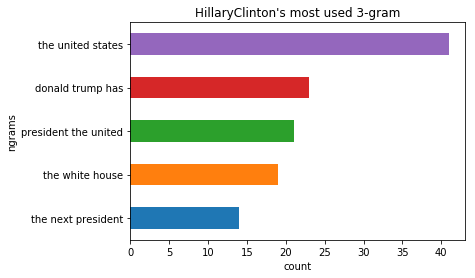

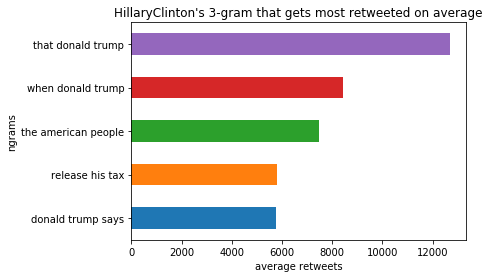

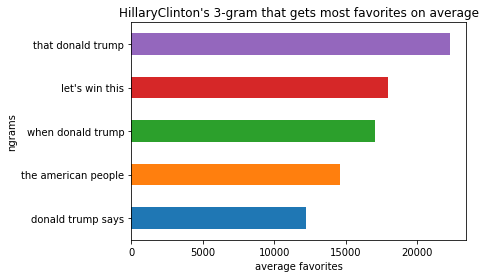

In [39]:
n_gram_dist()

# Location Analysis of the Tweets

In [29]:
#extracting states in USA
states = dict()
with open('us_states2.csv', encoding = "UTF-8") as f:
    n = 0
    for i in f:
        i.replace('\ufeff', '')
        i.replace('\n', '')
        states[i]=n
        
        n+=1
states = list(states.keys())
for i in range(len(states)):
    states[i] = (states[i].replace('\ufeff', '')).replace('\n', '')
    
    
#extracting the winners in each states to be used in the next function
winner = list()
with open('winner.csv', encoding = "UTF-8") as f:
    n = 0
    
    for i in f:
        if n > 0:
            k = i.split(",")
            k[1]=k[1].replace('\n', '') 
            winner.append(tuple(k))

        
        n+=1
winner
winner_df = pd.DataFrame(winner, columns = ['state', 'winner'])
state_ls = list(winner_df['state'])
state_lw_cs = [each_string.lower() for each_string in state_ls]
state_lw_cs
winner_df['state_lc'] = state_lw_cs
winner_d = winner_df.drop(columns = ['state']).set_index("state_lc", inplace=False)


def location(x, l = states):
    a = list()
    for i in x:
        for j in l:
            if j in i:
                if j not in a:
                    a.append(j)
    if len(a) == 0:
        return None
    else:
        return a
location_udf = udf(location, ArrayType(StringType()))

def location_dist():
    
    a = True
    print("Let's explore the states that were part of the tweets of Trump or hilary. \n " +
    "What we will do is ask you a few questions to formulate a query for \n "+
          "plotting information gathered about states from the tweets.")
    
    #preparing data
    loc_tweets = tweets_tok.withColumn('location', location_udf(col('words_fil')))
    data_loc_h = loc_tweets.filter('location is not null').filter('handle == "HillaryClinton"')\
            .select('handle','retweet_count','favorite_count',explode('location').alias('location'))
    data_loc_t = loc_tweets.filter('location is not null').filter('handle == "realDonaldTrump"')\
            .select('handle','retweet_count','favorite_count',explode('location').alias('location'))
    
    #interactive program
    while a:
        
        tw = input("Whose tweets would you like to analyse \n "+
                   "enter 'H' for Hilary, 'T' for Trump (return to quit): \n ")
        if tw.lower() == "h":
            person = "HillaryClinton"
            data_loc = data_loc_h
            break
        elif tw.lower() == "t":
            person = "realDonaldTrump"
            data_loc = data_loc_t
            break

    #data for plotting
    data2 = data_loc.groupBy('location').agg(count('handle').alias('total_tweets'),\
                                 sum("retweet_count").alias("total_retweet"),\
                                 mean("retweet_count").alias("mean_retweet"),\
                                 sum("favorite_count").alias("total_favorite"),\
                                 mean("favorite_count").alias("mean_favorite"))\
                                .sort('total_tweets', ascending=False)
    print("Top 20 states and the information about tweets from "+ person +" related to the respective state")

    data2.show(20)
    
    while a:
        print()
        q = input("Would you like to see graphs for the above information? enter YES or NO (return to quit): ")
        print()
        
        if q.lower() == "yes":
            s =True
            print("The graphs are of the Top 10 states that came in tweets from "+ person + 
              " there are 3 visualisation, one for the top most tweeted states " + 
                  "second for the states, when mentioned in a tweet gets most retweets on average, and " +
                  "third for the states, when mentioned in a tweet gets most favorites on average")
            break
        elif q.lower() == "no":
            s =False
            break
    
    #plotting the graphs
    while s:
        ct = data2.select('location', 'total_tweets').\
            toPandas().head(10)
        ct.plot('location', 'total_tweets',kind = 'barh', title = "top 10 states most mentioned in a tweet by "+ person, legend = False)
        plt.show()
        rt = data2.sort('mean_retweet',ascending=False).select('location', 'mean_retweet').\
            toPandas().head(10)
        rt.plot('location', 'mean_retweet',kind = 'barh', title = "top 10 states whise tweets by "+ person +" are most retweeted on average", legend = False)
        plt.show()
        ft = data2.sort('mean_favorite',ascending=False).select('location', 'mean_favorite').\
            toPandas().head(10)
        ft.plot('location', 'mean_favorite',kind = 'barh', title = "top 10 states whise tweets by "+ person +" are most favorited on average", legend = False)
        plt.show()
        s = False
    
    #Providing information about a particular state
    while a:
        com = input("enter the name of a state you would like to get comparison for, \n  write 'no' if you want to skip this (return to quit): ")
        if com.lower() == "no":
            print("bye!")
            break
        else:
            if com.lower() in state_lw_cs:
                print("For state " + com.title() +" information about Hilary's tweet is below" )
                data_loc_h.groupBy('location').agg(count('handle').alias('total_tweets'),\
                                 sum("retweet_count").alias("total_retweet"),\
                                 mean("retweet_count").alias("mean_retweet"),\
                                 sum("favorite_count").alias("total_favorite"),\
                                 mean("favorite_count").alias("mean_favorite")).\
                                filter('location == "{}"'.format(com.lower())).show()
                print("For state " + com.title() +" information about Trump's tweet is below" )
                data_loc_t.groupBy('location').agg(count('handle').alias('total_tweets'),\
                                 sum("retweet_count").alias("total_retweet"),\
                                 mean("retweet_count").alias("mean_retweet"),\
                                 sum("favorite_count").alias("total_favorite"),\
                                 mean("favorite_count").alias("mean_favorite")).\
                                filter('location == "{}"'.format(com.lower())).show()
                print("The winner in state " + com.title() +" in 2016's election was " +  list(winner_d.loc[com.lower()])[0])
            else:
                print("you chose the wrong state, please try again!")
                
                
    pass
        


Let's explore the states that were part of the tweets of Trump or hilary. 
 What we will do is ask you a few questions to formulate a query for 
 plotting information gathered about states from the tweets.
Whose tweets would you like to analyse 
 enter 'H' for Hilary, 'T' for Trump (return to quit): 
 h
Top 20 states and the information about tweets from HillaryClinton related to the respective state
+------------+------------+-------------+------------------+--------------+------------------+
|    location|total_tweets|total_retweet|      mean_retweet|total_favorite|     mean_favorite|
+------------+------------+-------------+------------------+--------------+------------------+
|    virginia|          11|        17465|1587.7272727272727|         48300| 4390.909090909091|
|     indiana|          11|        20002|1818.3636363636363|         34530| 3139.090909090909|
|        ohio|          10|        11670|            1167.0|         30153|            3015.3|
|  washington|           9

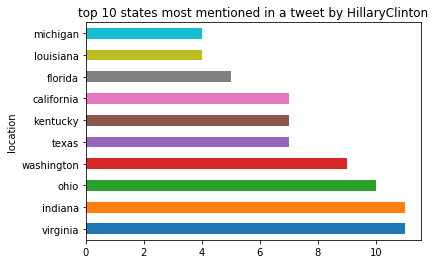

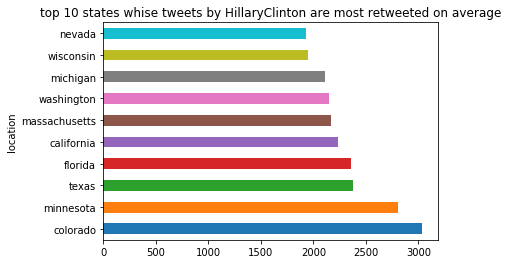

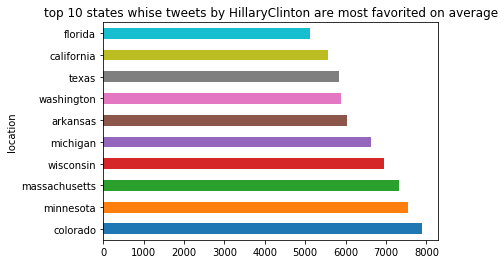

enter the name of a state you would like to get comparison for, 
  write 'no' if you want to skip this (return to quit): iowa
For state Iowa information about Hilary's tweet is below
+--------+------------+-------------+------------+--------------+-------------+
|location|total_tweets|total_retweet|mean_retweet|total_favorite|mean_favorite|
+--------+------------+-------------+------------+--------------+-------------+
|    iowa|           1|          637|       637.0|          2047|       2047.0|
+--------+------------+-------------+------------+--------------+-------------+

For state Iowa information about Trump's tweet is below
+--------+------------+-------------+------------------+--------------+-----------------+
|location|total_tweets|total_retweet|      mean_retweet|total_favorite|    mean_favorite|
+--------+------------+-------------+------------------+--------------+-----------------+
|    iowa|          76|       235887|3103.7763157894738|        708500|9322.368421052632|


In [30]:
location_dist()


# Predictive Modelling Using Naive Bayes Classified

In [17]:
#preparing functions to run the naive_bayes algorithm
label_stringIdx = StringIndexer(inputCol = "handle", outputCol = "label")
countVectors = CountVectorizer(inputCol="ngrams", outputCol="features", vocabSize=10000, minDF=5)
#pipeline = Pipeline(stages=[countVectors, label_stringIdx])


#interactive program to get accuracy of different N-grams that can be used for modelling these tweets. 
#note that the goal of this program is not to provide a predictor, but to suggest the best technique if one would
#like to create a predictor
def naive_bayes():
    a = True
    while a:
        n = input("For the ngram analysis, enter how many words do you want to analye, anywhere from 1 to 5 (return to quit): ")
        try:
            int(n)
        except:
            n = 9
        if int(n) in list(range(1,6)):
            break
    
    #Choosing the data set to be used
    while a:
        data = input("would you like the stop words removed? Y for yes and N for no (return to quit): ")
        if data.lower()== "y":
            dat = "without stop words"
            data_frame = tweets_tok
            col_name = 'words_fil'
            break
        elif data.lower() == "n":
            dat = "with stop words"
            data_frame = w
            col_name = 'words'
            break
    
    #creating teh function
    ngram = NGram(n = int(n), inputCol=col_name, outputCol="ngrams")
    
    #creating Ngrams
    n_gram_df = ngram.transform(data_frame).select('handle', 'ngrams')
    
    while a:
        tr = input("Enter the ratio of training data of your complete data strictly between 0 and 1 (return to quit): ")
        try:
            k = float(tr)
        except:
            k = 5
        if 0< k<1:
            break






    pipeline = Pipeline(stages=[countVectors, label_stringIdx])
    pipelineFit = pipeline.fit(n_gram_df)
    dataset = pipelineFit.transform(n_gram_df)
    
    (trainingData, testData) = dataset.randomSplit([k, 1-k], seed = 786)
    
    
    nb = NaiveBayes(smoothing=1)

    model = nb.fit(trainingData)
    predictions = model.transform(testData)
   
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
    acc = 100*evaluator.evaluate(predictions)
    print("Accuracy of "+ n +" gram " + dat +" "+ str(acc)+ "%")
    pass

#Following, although not used in the iteraction, tells the top 10 tweets for a certain candidate from the test set,
#that are most likely to be the tweets for that specific candidate
#predictions.filter(predictions['prediction'] == 0) \
#    .select("ngrams","handle","probability","label","prediction") \
#    .orderBy("probability", ascending=False) \
#    .show(n = 10, truncate = 30)


In [18]:
naive_bayes()




For the ngram analysis, enter how many words do you want to analye, anywhere from 1 to 5 (return to quit): 2
would you like the stop words removed? Y for yes and N for no (return to quit): N
Enter the ratio of training data of your complete data strictly between 0 and 1 (return to quit): 0.7
Accuracy of 2 gram with stop words 78.14901993942823%


# Spanish Tweets Analysis

In [19]:
# Analysing Spanish tweets
# Although there were other labels, upon data exploration, we realised that their were mainly two languages:
# spanish, labelled as es, and English, anything not labelled es.


print("Here we are going to explore the spanish tweets made by Hilary Clinton. \n"+
"Reason being, in our data set Trump made no tweets in spanish, and we are not surprised \n ")

print("Now we will do a tabular visualisation on the mean favorites and retweets of the spanish tweets")
print()
print("Hilary's summary of tweets by language")
tweets_tok.filter("lang == 'es'").filter("handle == 'HillaryClinton'").\
agg(count("handle").alias('total_spanish'), sum('retweet_count').alias("total_retweets"),\
     mean('retweet_count').alias("avg_retweets"),sum('favorite_count').alias("total_fav"),\
    mean('favorite_count').alias("avg_fav")).show()

tweets_tok.filter("lang != 'es'").filter("handle == 'HillaryClinton'").\
agg(count("handle").alias('total_non_spanish'), sum('retweet_count').alias("total_retweets"),\
     mean('retweet_count').alias("avg_retweets"), sum('favorite_count').alias("total_fav"),\
    mean('favorite_count').alias("avg_fav")).show()

print("trump's summary of tweets by language")
#Trump had no tweet that was written in spanish, from the data base we had
tweets_tok.filter("handle != 'HillaryClinton'").\
agg(count("handle").alias('total_non_spanish'), sum('retweet_count').alias("total_retweets"),\
     mean('retweet_count').alias("avg_retweets"), sum('favorite_count').alias("total_fav"),\
    mean('favorite_count').alias("avg_fav")).show()

hispanic = dict()
with open('hispanic.csv', encoding = "UTF-8") as f:
    n = 0
    for i in f:
        if n>0:
            j = i.split(",")
            a = j[0].replace('\xa0', '')
            hispanic[a.lower()]=j[1]

        n+=1
hisp_list = list(hispanic.items())

for i in range(len(hisp_list)):
    hisp_list[i] = (hisp_list[i][0].title(),hisp_list[i][1], list(winner_d.loc[hisp_list[i][0]])[0] )

print("Table of top 10 Hispanic Population (Spanish speaking) states in 2016")
pd.DataFrame(hisp_list, columns = ["State", "Hispanic Population in 2016", "Winner in State"])


Here we are going to explore the spanish tweets made by Hilary Clinton. 
Reason being, in our data set Trump made no tweets in spanish, and we are not surprised 
 
Now we will do a tabular visualisation on the mean favorites and retweets of the spanish tweets

Hilary's summary of tweets by language
+-------------+--------------+------------------+---------+------------------+
|total_spanish|total_retweets|      avg_retweets|total_fav|           avg_fav|
+-------------+--------------+------------------+---------+------------------+
|          102|        103022|1010.0196078431372|   189675|1859.5588235294117|
+-------------+--------------+------------------+---------+------------------+

+-----------------+--------------+------------------+---------+-----------------+
|total_non_spanish|total_retweets|      avg_retweets|total_fav|          avg_fav|
+-----------------+--------------+------------------+---------+-----------------+
|             3124|       9522224|3048.0870678617157| 2142

,State,Hispanic Population in 2016,Winner in State
0,New Mexico,49%,Hilary
1,Texas,39%,Trump
2,California,39%,Hilary
3,Arizona,31%,Trump
4,Nevada,29%,Hilary
5,Florida,25%,Trump
6,Colorado,21%,Hilary
7,New Jersey,20%,Hilary
8,New York,19%,Hilary
9,Illinois,17%,Hilary


# Popular Hashtags Word Clouds

In [23]:
# file prepared to be used only for this and next step that requires the use of hashtags and @ signs
text_raw2 = tweets_raw.select('handle', (regexp_replace('text', "[^\'#@0-9a-zA-Z\\s]", "")).alias('text'), 'is_retweet', 'original_author', month('time').alias('month') ,'place_name', 'lang', 'retweet_count', 'favorite_count')
# Tokenising the text_raw2 file for use with the hashes.

tokenizer = Tokenizer(inputCol="text", outputCol="words") #"words_tok")
hashes_one = tokenizer.transform(text_raw2)

hashes = hashes_one.select('handle',explode('words').alias('hashtags'), 'retweet_count', 'favorite_count').filter(col("hashtags").contains("#"))

hil_hashes = hashes.filter('handle == "HillaryClinton"').groupby('hashtags').\
agg(count('handle').alias('total'), mean('retweet_count').alias('avg_retweet'), mean('favorite_count').alias('avg_favorite')).\
sort('total', ascending = False).toPandas()
trmp_hashes = hashes.filter('handle == "realDonaldTrump"').groupby('hashtags').\
agg(count('handle').alias('total'), mean('retweet_count').alias('avg_retweet'), mean('favorite_count').alias('avg_favorite')).\
sort('total', ascending = False).toPandas()


# Since we cannot use word cloud here, as it is not part of our server and due to limitations it was not runnable
# one of the project partners server's account, we move the analysis to a local machine and save the spark rdd as a text file


output_model = "hashes/hilary_hashes"
if os.path.isdir(output_model):
    shutil.rmtree(output_model) # Remove the previous file to create a new one
hil_hashes.to_csv(output_model)
if os.path.isdir(output_model):
    shutil.rmtree(output_model)
output_model = "hashes/trump_hashes"
trmp_hashes.to_csv(output_model)



In [ ]:
# The following will be ran on a different Jupyter locally, as we had encountered problems with installing
# word cloud on the server 

from wordcloud import WordCloud as wc
trump_hash = pd.read_csv("trump_hashes", header = 0)
hilary_hash = pd.read_csv("hilary_hashes", header = 0)

def wordCl_hashes():
    while True:
        person = input("Please enter the candidates name, whose hashtages you want to analyse: \n \
        t for Trump and H for Hilary  ")
        if (person.lower() ==  "t"):
            data_fr = trump_hash
            p = "Trump's "
            break
        elif (person.lower() ==  "h"):
            p = "Hilary's "
            data_fr = hilary_hash
            break
        else:
            print("We did not identify this candidate")
    d = {}
    df = {}
    dr = {}
    for k, a, x,r,f in data_fr.values:
        d[a] = x
        df[a] = f
        dr[a] = r
    

    for i in ["used", "retweeted", "favorited"]:
        if i == "used":
            dct = d
        elif i == "retweeted":
            dct = dr
        else:
            dct = df
        wcs = wc()
        wcs.generate_from_frequencies(frequencies = dct)
        plt.figure(figsize = (15,10))
        plt.imshow(wcs, interpolation="bilinear")
        plt.axis("off")
        plt.title(p +"most "+ i+ " hashtags", fontdict = {'fontsize' : 50})
        #plt.savefig(person+"_"+i)
        #plt.close()

        plt.show()

    pass
wordCl_hashes()

# Hashtags to People network visualisation

In [21]:
def hashes_finder(x):
    a = list()
    y = x.split()
    for i in y:
        if "#" in i:
            a.append(i)
    if len(a) == 0:
        return None
    else:
        return a
    pass

hashes_udf = udf(hashes_finder, ArrayType(StringType()))

def at_finder(x):
    a = list()
    y = x.split()
    for i in y:
        if "@" in i:
            a.append(i)
    if len(a) == 0:
        return None
    else:
        return a
    pass

at_udf = udf(at_finder, ArrayType(StringType()))

def network_acct_hash(word):
    data = text_raw2.filter(col("text").contains("#")).filter(col("text").contains("@")).\
    withColumn('hash', hashes_udf(col('text'))).withColumn('at_rate', at_udf(col('text'))).\
    select('hash', 'at_rate').select("hash", explode("at_rate").alias("at_rate")).\
    select(explode("hash").alias("hash"), "at_rate")
    if "#" in word: 
        df = data.filter(col("hash") == word).toPandas()
        txt = "hash"
    elif "@" in word: 
        df = data.filter(col("at_rate") == word).toPandas()
        txt = "acct"
    else:
        return "sorry you chose the wrong arguments, it should either be a hashtag or account reference."
    if len(df) == 0:
        print("sorry we did not find the "+ word + " in the tweets")
    else:
        G  = nx.from_pandas_dataframe(df,"hash","at_rate")
        plt.figure(figsize = (9,8))
        nx.draw_networkx(G,with_labels = True,font_size = 10,
                         font_color = "k",
                         font_family  = "DejaVu Sans",
                         node_shape  = "h",node_color = "lightblue",
                         node_size = 1000,linewidths = 10,
                         edge_color = "grey",alpha = .6)
        plt.savefig(word+txt)
    pass


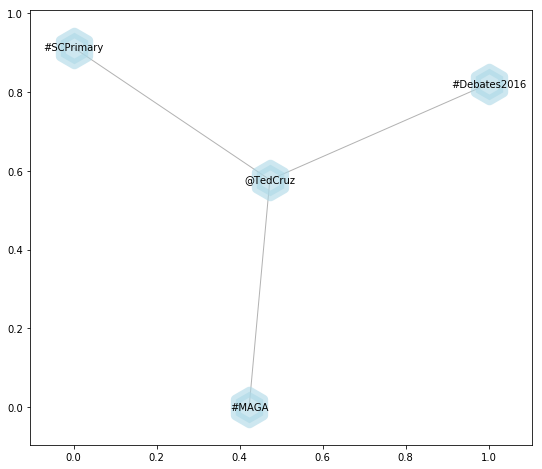

In [28]:
network_acct_hash("@TedCruz")


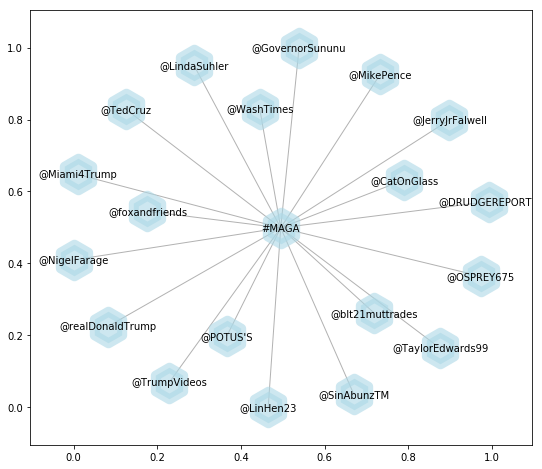

In [25]:
network_acct_hash("#MAGA")